<a href="https://colab.research.google.com/github/TabithaSona/LeNet5C/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install torch, torchvision, torchaudio, matplotlib, numpy, tqdm

ERROR: Invalid requirement: 'torch,': Expected end or semicolon (after name and no valid version specifier)
    torch,
         ^


Torch(Main kitchen) = Pytorch the main framework it provides the core functions to define the neural network layers, the math operations and the magic behind calculating gradients

Torchvision(speacialized baking tool) = a library that works with Pytorch specifically for CV tasks, it contains the standard datasets like MNIST, CIFAR-10, imageNet are all preloaded here, tools for transforming images like resizing cropping normalizing and converting them to tensors, we need it to load the MNIST dataset and preparing the images increadibly easy with just few lines of codes

torchaudio(not used in this project) = sister library to torchvision but for audio data, often installed alognside torch and torchvision in a standart pytorch installation to cover all bases

matplotlib(food photographer) = library for creating graphs and plots in python, to create visualization showing the loss and accuracy of the model

numpy(the prep) = fundamental package for numeraical computation in python it handles large arrays and metrics of numbers, used for simple preparatory data manipulation and sometimes to convert the result back for plotting

tqdm = library the instanstly creates smart progress bars, wrapping a tqdm around your training loop gives you a beutiful progress bar that shows, how many batches have been proccessed, how long it takes, an estimate of how much it will take, this is immensely helpful for debuggin and patience


In [33]:
import torch
import torch.nn as nn #nn contain the prebuilt layers
import torch.nn.functional as F #contains functions like tanh

class LeNet5(nn.Module): #LeNet class inherits from torch nn.Module the base class for all neural network modules in pytorch, this allows the class to track its layers, parameters, and provide methods for training and evaluation
  def __init__(self, num_classes=10): #initialized the layers of the network these layers are divided into 2 main parts feature extraction and classification
    super(LeNet5, self).__init__() #required to properly initialize the parent module class
    #feature extraction layers
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0) #2D convolutional layer with a single input channel for grayscal images and 6 output channels, uses 5x5 kernel
    self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2) #average pooling layer that reduces the spatial dimensions of the feature maps by half, performs local averaging over 2x2 regions, stride=2 means no overlap reducing 28x28 input to 14x14
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0) #takes 6 output channels from previous layers as input and produces 16 output channels
    self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2) #reduces the 10x10 input from C3 to 5x5
    self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0) #third and final convolutional layer which produces 120 output channels

    #classification layers
    self.fc1 = nn.Linear(120, 84) #a fully connected layer(linear) that takes the flattened output of the convolutional layers and transforms it into 84 outputs
    #self.fc2 = nn.Linear(84, num_classes) #it maps 84 outputs to num_classes(10 for handwritten digits 0-9) represensting the final class scores
    self.rbf_centers = nn.Parameter(torch.randn(num_classes, 84)) #RBF layer parameters as in the paper

    #initialize weights as suggested in paper
    self._initialize_weights() #to set the initial values of the networks weights and biases which can help with training stability and performance

  def _initialize_weights(self): #helper method iterates through all the modules(layers) defined in the network and initializes their weights and biases
    for m in self.modules():
      if isinstance(m, nn.Conv2d): #for convolitional layers it uses xavier_uniform initialization for the weights and sets the baises to 0
        nn.init.xavier_uniform_(m.weight) #xavier initialzation is a common strategy that helps to keep the variance of activations consistent across layers
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear): #for linear layers it uses normal_ initialization with a small standard deviation for the weights and sets the biases to 0
        nn.init.normal_(m.weight, 0, 0.1) #std =0.1 for linear layers a simple way to start with small random weights, biases are initialized to zero
        nn.init.constant_(m.bias, 0)

  def forward(self, x): #defines the sequence of operations for data flowing through the network, this is where the layers are connected to form the network architecture
    #input 32*32 (will be resized from 28x28)
    x = torch.tanh(self.conv1(x)) #ouput 28x28x6, input data x first goes through the 1convolutional layer, and then a hyperbolic tangent activation function is applied, although ReLu is more popular today
    x = self.avg_pool1(x) #output 14x14x6   result is downsamples by the first average pooling layer, reduces the feature map size and make the model more robust to shifts and distortions
    x = torch.tanh(self.conv2(x)) #output 10x10x16  #same as above just the kernel size and the input and output channels differ
    x = self.avg_pool2(x)  #output 5x5x16
    x = torch.tanh(self.conv3(x)) #output 1x1x120

    x = x.view(x.size(0), -1)  #flatten  after the convolutional and pooling the final output tensor is flattened, .view() = method reshapes the tensor into a 2d format, with the first dimesntions beign the batch size(x.size(0)) and second dimension(-1) automatically calculates to be the total number of features
    x = torch.tanh(self.fc1(x)) #output 84  flattened features are passes through the first fully connected layer with a tanh activation
    #RBF computation
    x = x.unsqueeze(1) #add dimension for broadcasting
    distances = torch.sum((x - self.rbf_centers)**2, dim=2)
    # x = self.fc2(x) #output 10   the output of this layer represents the unnormalized scores for each class
    # return x  #returns the final output tensor, typically a softmax function would be applied to these socres during training to convert them into probabilities
    return -distances #negative distnaces (smaller distance = higher output)

CREATE DATA LOADERS

In [37]:
import torch #for handling data
from torchvision import datasets, transforms #part of pytoch library that provides utilities for computer vision tasks, like loading standard datasets and modifying images(transforms)

def get_mnist_loaders(batch_size = 128): #data function, job is to package all the steps for getting the MNIST data, batch size means we will process 128 images at a time by default
  #transformations: resize to 32x32 and normalize
  transform = transforms.Compose([
      transforms.Resize((32, 32)), #LeNet architecture is designed to expect a 32x32 pixel image as its input, as the standard MNIST images are 28x28, this line resizes the image, it is a critical step to match the papers specification
      transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), #data augmentation enhancement as mentioned in the paper
      transforms.ToTensor(), #this converts the image from a python imaging library(PIL) format into a pytorch tensor, a tensor is essentially a multi dimensional array of numbers that pytorch can perform fast calculations on, it also automatically scales the pixel values from [0, 255] to the range [0.0, 1.0]
      transforms.Normalize((0.1307, ), (0.3081, )) #the values of the input pixels are normalized so that the background level white corresponds to a value of -0.1 and the foreground corresponds to 1.175, this makes the mean input roughly 0 the varience roughly 1 which accelerate learning
  ]) #(0.1307) = mean of the MNIST dataset, (0.3081) = standard deviation of MNIST dataset,
#formula is normalized_pixel = (original_pixel - mean)/std , this transformation changes the data distribution , which helps the neural network learn faster and more stably it achieves the same goal as the papers method
  #downaload and load training data
  train_dataset = datasets.MNIST( #built in function that knows how to get the MNIST dataset
      root='./data', #download the data into a folder names data in the current directory
      train=True, #means we want the traning split of the data(60,000 images)
      download=True, #if you do not have it download it from the internet
      transform=transform  #and apply the steps of the tranformations on the train dataset(resize, toTensor, normalize) for every image
  )

  #download and load the test data
  test_dataset = datasets.MNIST( #identical to the train datasets function
      root='./data',
      train=False, #but this command specifies that we want to test split the data(10,000 images), this is the data we will use to evaluate our models performance after training
      download=True,
      transform=transform
  )

  #create data loaders
  train_loader = torch.utils.data.DataLoader( #the feeding machine, as we can't process all 60,000 images at once, a data loader is like a smart conveyor belt that feeds the data to the model during training
      train_dataset, #the data to use
      batch_size=batch_size, #only put 128 images on the conveyor belt at a time
      shuffle=True #shuffle the 60,000 images before each training cycle, this is crucial to prevent the model from learning the order of the data instead of the pattern within it
  )

  test_loader = torch.utils.data.DataLoader( #test data also needs a conveyor belt
      test_dataset,
      batch_size=batch_size,
      shuffle=False #but no shuffle, the order doesn't matter for evaluation we just need to get a score, this makes the evaluation consistent
  )

  return train_loader, test_loader #return the 2 configured conveyor belts one for feeding training data and one for feeding test data, main program can now use these to train and evalute the LeNet model

IMPLEMENT THE TRAINING LOOP

In [38]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
import torch.nn as nn #core neural network library
import torch.optim as optim #contains the optimization algorithms(the learning rules)
from tqdm import tqdm #for the progress bar


def train_model(): #the workshop
    # Set device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}") #this ask pytorch do i have a powerful GPU(cuda) to use or should i just use the regular CPU
    #GPU makes computation much faster
    # Get data loaders
    train_loader, test_loader = get_mnist_loaders(batch_size=128) #this calls the function, set up the two conveyor belt with the prepared MNIST data and bring them here

    # Initialize model, loss function, and optimizer
    model = LeNet5().to(device) #this creates an instance of your LeNet-5 model and mkeas sure it's places on the correct device, this is the empty untrained brain
    criterion = nn.CrossEntropyLoss() #criterion=loss function is the performance measure, it's a mathematical formula that calculates how wrong the models predictions are, CrossEntroy = standard function for classification task, the goal of training is to minimize this number
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005) #the optimizer is the gradient based learning algorithm itself, SGD=stochastic gradient descent, fundamental algorithm described in the paper, model.parameter()=this tell the optimizer that here are all the weights and biases in the model that you can adjust to try and reduce the loss
    #lr = learning rate, how big of a turn you make on the parameters, momentum=a technique to help optimizer avoid getting stuck in small valleys and making it converge faster, weight_decay=a form of regularization to prevent overfitting(making the model simpler)
    # Training parameters, the training plan
    num_epochs = 20 #an epcoh is one full pass through the entire training dataset, we will do this 20 times
    train_losses = []  #the empty lists are like logbooks where we will record the models performance after each epoch
    train_accuracies = []
    test_accuracies = []

    # Training loop, core training loop, the learning
    for epoch in range(num_epochs): #for each epoch we
        # Training phase
        model.train() #set the model to train() mode(enables features like dropout)
        running_loss = 0.0 #resets our counters for loss and accuracy
        correct = 0
        total = 0
        #start looping over the train_loader, the tqdm wrapper gives us a nice progess bar, move the current batch of data(128 images) to the GPU/CPU
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")): #the package delivered by train_loader is a tuple containing two things data=a tensor containing a batch of images it shapes[128, 1, 32, 32] and target=a tensor containing the correct label for each image in the batch its shape is [128], enumerate() function just keeps a counter each time a new barch is retrieved it increments the counter and return both the counter value and the itsel
 #batch_idx=0 for the first batch, batch_idx=1 for the second batch and so on,    tqdm adds a visual progress bar around  it,   desc parameter=will show epoch 1/20 ike this, digital display
            data, target = data.to(device), target.to(device) #this line moves the data and target tensors from the computers main memory to the processor where the model is located for pytorch to perform calculations

            # Zero gradients
            optimizer.zero_grad() #pytorch accumulates gradients before doing a new calculation we must reset the gradient from the previous batch to zero, like wiping a blackboard clean before doinf a new math problem

            # Forward pass
            output = model(data) #input image data is passed through the Lenet-5 model to get a prediction output
            loss = criterion(output, target) #the loss function calculates the discrepancy between the models' prediction and the correct answer(target)

            # Backward pass and optimize, backpropagation
            loss.backward() #it calculates the gradient for every parameter in the model, the gradient tells us which direction we need to tweak to make the loss decrease
            optimizer.step() #this the learn step, the optimizer used the calculated gradients to actually turn all the knobs in the model, change the parameters(weights, biases)

            # Track metrics
            running_loss += loss.item() #add up the loss for this batch
            _, predicted = output.max(1) #find the predicted class(the class with the highest score)
            total += target.size(0)
            correct += predicted.eq(target).sum().item() #count how many predictions in this batch were correct

        # Calculate training metrics
        train_loss = running_loss / len(train_loader) #after finishing all batches in the epochs we calculate the average loss and accuracy for the entire training set and log it
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluation phase, validation
        test_acc = evaluate_model(model, test_loader, device) #after training on the set for one epoch, we evaluate the model on the unseen test set, this tells us how well the model generalized to new data it has never seen before
        test_accuracies.append(test_acc) #print the report card fot this epoch

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return model, train_losses, train_accuracies, test_accuracies

def evaluate_model(model, test_loader, device): #to test the model
    model.eval() #switches the model to evaluation mode(disabling things like dropout)
    correct = 0
    total = 0
    #pytorch automatic gradient tracking is turned off, it reduces memory usage, code runs much faster, the model should not learn from the test set, unbiased measure of performance
    with torch.no_grad(): #this is a critical switch that tell pytorch not to calculate gradients, this makes the evaluation much faster and uses less memeory becuase we are not learning just testing
        for data, target in test_loader: #loop iterates thorugh the test_loader, placing new data and its correct answer on each model one batch at a time
            data, target = data.to(device), target.to(device) #this moves the current batch of data and labels to the same device where the model is located
            outputs = model(data) #batch of test images is passed through the model, the model performs its calculations and produces an output tensor of shape[128, 10] it contains 128 rows one for each image and 10 columns one for each digit, the values in each row are scores or confidence for each digit class, a higher value means the model is more confidant that the image is that digit
            _, predicted = outputs.max(1) #this line takes the models' answer sheet outputs and finds the final predicted answer for each image, max() function finds the maximum value along dimension 1, it returns two things = the actual highest value we don't need it so we throw it away by assigning it to _, the index position of that maximum value that is the models final prediction we store that in the variable predicted
            total += target.size(0) #target.size(0) is the number of images in the current batch, this adds that number to the total counter after looping through all batches the total = size of the entire test set(10,000)
            correct += predicted.eq(target).sum().item() #compare the models predictions with the correct answer the .eq() function does an element wise equal to comparison and returns a tensor of True/False values, sum()=adds up all the 1s(correct answer) in this batch, item()=coverts the single number tensor results into a regular python number
   #adds all this number of correct answers to the correct counter
    accuracy = 100. * correct / total
    return accuracy

if __name__ == "__main__": #scripts entry point,
    model, train_losses, train_accuracies, test_accuracies = train_model() #runs the train_model() function and then saves the trained models learned parameters to a file
    #this allows you to load the trained model later without having to retrain it
    # Save model
    torch.save(model.state_dict(), "lenet5_mnist.pth")
    print("Model saved as lenet5_mnist.pth")

Using device: cpu


Epoch 1/20: 100%|██████████| 469/469 [00:48<00:00,  9.71it/s]


Epoch 1: Train Loss: 1.5349, Train Acc: 71.92%, Test Acc: 84.11%


Epoch 2/20: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]


Epoch 2: Train Loss: 0.3197, Train Acc: 90.33%, Test Acc: 92.62%


Epoch 3/20: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]


Epoch 3: Train Loss: 0.2381, Train Acc: 92.72%, Test Acc: 93.91%


Epoch 4/20: 100%|██████████| 469/469 [00:46<00:00, 10.17it/s]


Epoch 4: Train Loss: 0.1974, Train Acc: 94.09%, Test Acc: 94.69%


Epoch 5/20: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]


Epoch 5: Train Loss: 0.1741, Train Acc: 94.78%, Test Acc: 94.83%


Epoch 6/20: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]


Epoch 6: Train Loss: 0.1510, Train Acc: 95.47%, Test Acc: 96.04%


Epoch 7/20: 100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 7: Train Loss: 0.1406, Train Acc: 95.67%, Test Acc: 96.35%


Epoch 8/20: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]


Epoch 8: Train Loss: 0.1283, Train Acc: 96.09%, Test Acc: 96.69%


Epoch 9/20: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]


Epoch 9: Train Loss: 0.1206, Train Acc: 96.30%, Test Acc: 96.62%


Epoch 10/20: 100%|██████████| 469/469 [00:46<00:00, 10.19it/s]


Epoch 10: Train Loss: 0.1174, Train Acc: 96.41%, Test Acc: 96.43%


Epoch 11/20: 100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 11: Train Loss: 0.1091, Train Acc: 96.69%, Test Acc: 97.08%


Epoch 12/20: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]


Epoch 12: Train Loss: 0.1015, Train Acc: 96.85%, Test Acc: 96.89%


Epoch 13/20: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


Epoch 13: Train Loss: 0.0995, Train Acc: 96.94%, Test Acc: 97.60%


Epoch 14/20: 100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 14: Train Loss: 0.0921, Train Acc: 97.19%, Test Acc: 97.48%


Epoch 15/20: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]


Epoch 15: Train Loss: 0.0879, Train Acc: 97.25%, Test Acc: 97.42%


Epoch 16/20: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]


Epoch 16: Train Loss: 0.0875, Train Acc: 97.34%, Test Acc: 97.51%


Epoch 17/20: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


Epoch 17: Train Loss: 0.0797, Train Acc: 97.47%, Test Acc: 97.89%


Epoch 18/20: 100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 18: Train Loss: 0.0804, Train Acc: 97.58%, Test Acc: 97.50%


Epoch 19/20: 100%|██████████| 469/469 [00:45<00:00, 10.21it/s]


Epoch 19: Train Loss: 0.0766, Train Acc: 97.59%, Test Acc: 97.63%


Epoch 20/20: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]


Epoch 20: Train Loss: 0.0726, Train Acc: 97.75%, Test Acc: 97.88%
Model saved as lenet5_mnist.pth


VISUALIZATION AND ANALYSIS

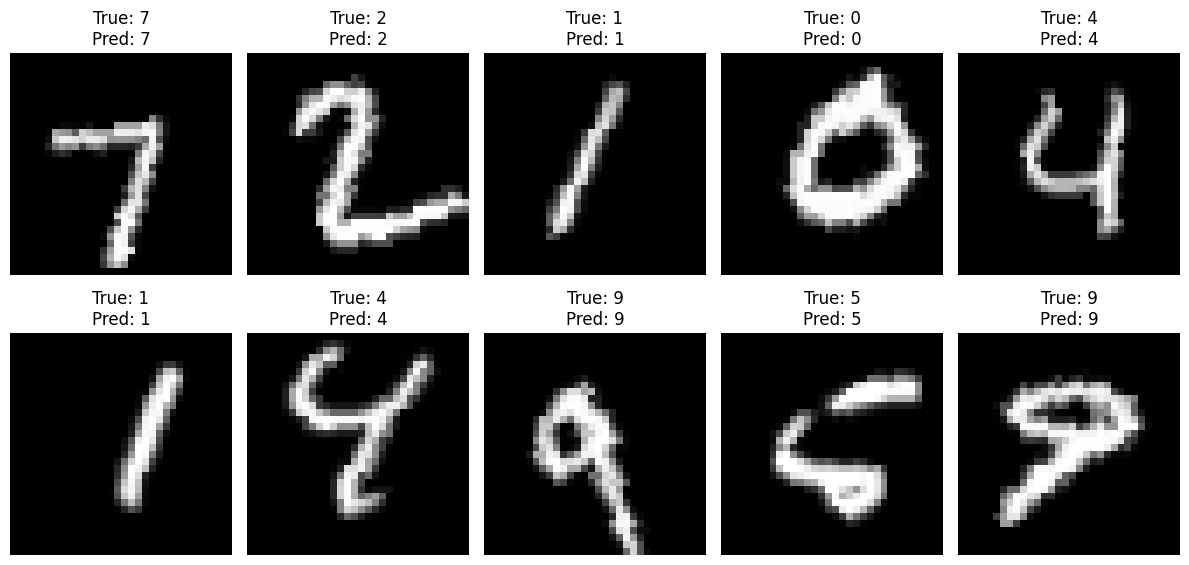

In [40]:
#visualize the training process and predictions results of machine learning model
import matplotlib.pyplot as plt
import numpy as np #for scientific computing in python
train_loader, test_loader = get_mnist_loaders()
#this function creates and saves plots for the model's loss and accuracy over time(epochs)
def plot_training_curves(train_losses, train_accuracies, test_accuracies): #3 inputs
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) #it creates a figure and a set of subplot, it sets up a figure and an array of 2 subplots(ax1, ax2) arranged in one row and two column, the figsize argument controls the size of the entire figure

  #plot loss
  ax1.plot(train_losses, label='Training Loss') #plots the train_losses data on the first subplot, label argument gives the line a name for the legend
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training Loss')
  ax1.legend() #display a legend on ax1 to identify the plotted lines using their labels
  ax1.grid(True)
#similar to above for second subplot
  #plot accuracy
  ax2.plot(train_accuracies, label='Training Accuracy')
  ax2.plot(test_accuracies, label='Test Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.set_title('Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout() #atumatically adjusts subplot parameters to give a tight layout preventing labels from overlapping
  plt.savefig('training_curves.png') #saves the entire figure as a png file
  plt.show() #displat the plot
#function displays a grid of images from a test dataset along models predictions
def visualize_predictions(model, test_loader, device, num_images=10): #takes a trained model, a test_loader and device and no. of images to visualize
  model.eval() #sets the model to evaluation mode
  images, labels = next(iter(test_loader)) #gets the first batch of images and their corresponding labels from the test_loader
  images, labels = images.to(device), labels.to(device) #moves the images and labels to the device

  with torch.no_grad(): #pytorch context manager that disables gradient calculation
    outputs = model(images[:num_images]) #feeds the first no. of images from teh batch into the model to get its raw output
    _, predicted = outputs.max(1)

  #plot images with predictions
  fig, axes = plt.subplots(2, 5, figsize=(12, 6)) #creates a new figure with a 2x5 grid of subplots for displaying the images
  axes = axes.ravel() #flatttens the 2d array of subplots into a 2d array

  for i in range(num_images): #to process each of 10 images
    axes[i].imshow(images[i].cpu().squeeze(), cmap='gray') #display ith image on the ith subplot
    axes[i].set_title(f'True: {labels[i].item()}\nPred: {predicted[i].item()}')
    axes[i].axis('off') #hides the axes and tick marks to make the plot cleaner

  plt.tight_layout()
  plt.savefig('predictions.png')
  plt.show()


if __name__ == "__main__":
  visualize_predictions(model, test_loader, device)


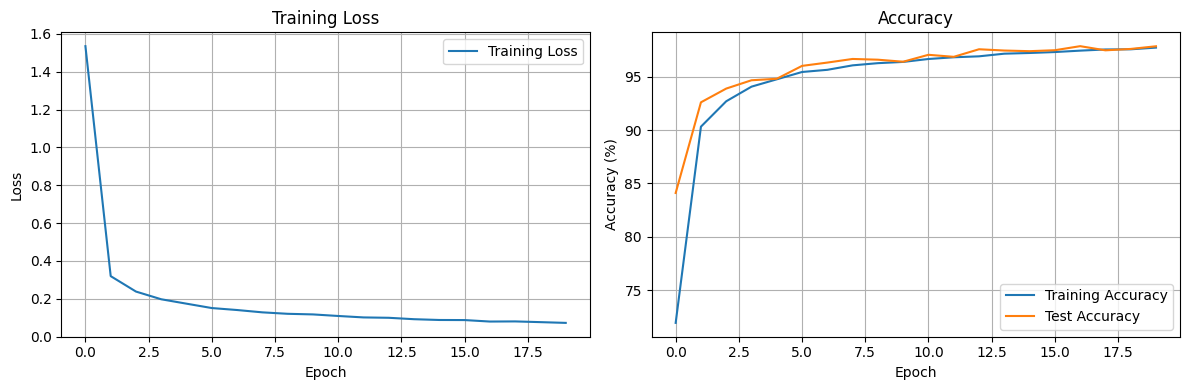

In [41]:
#create and show  the training curves
plot_training_curves(train_losses, train_accuracies, test_accuracies)


RUNNING THE COMPLETE PIPELINE

In [42]:
#final evaluation
final_accuracy = evaluate_model(model, test_loader, device)
print(f"Final Test Accuracy: {final_accuracy:.2f}%")

#compare with the paper results(they reported ~0.8% error rate)
error_rate = 100 - final_accuracy
print(f"Error Rate: {error_rate:.2f}%")
print("Paper Reported ~0.8% error rate wiht distortions")


Final Test Accuracy: 98.07%
Error Rate: 1.93%
Paper Reported ~0.8% error rate wiht distortions
